# IMPORTS

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
import os

# CONSTANTS

In [75]:
TRAIN_FILES_PATH = 'jpx-tokyo-stock-exchange-prediction/train_files'
NUMBER_OF_STABLE_STOCKS = 370
NUMBER_OF_DAILY_CHOSEN_STOCKS = 15
DAYS_PERIODS = [10, 21, 63]

In [76]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle//kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# PROCESS DATA

Submission format: our end goal

In [77]:
sample_submission = pd.read_csv(r'jpx-tokyo-stock-exchange-prediction\example_test_files\sample_submission.csv')
sample_submission

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4
...,...,...,...
111995,2022-02-28,9990,1995
111996,2022-02-28,9991,1996
111997,2022-02-28,9993,1997
111998,2022-02-28,9994,1998


In [78]:
stock_prices = pd.read_csv(f'{TRAIN_FILES_PATH}/stock_prices.csv')
stock_prices.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', x).lower() for x in stock_prices.columns]
stock_prices.head()

,row_id,date,securities_code,open,high,low,close,volume,adjustment_factor,expected_dividend,supervision_flag,target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [79]:
delisted_stocks = stock_prices[stock_prices['supervision_flag'] == True]['securities_code'].values

In [80]:
def get_stocks_traded_every_day(stock_prices_df):
    """Return stocks that are traded in every trading day in data and remove others"""
    traded_stock_per_date = stock_prices_df['date'].value_counts()
    stocks_by_descending_trade_count = stock_prices_df['securities_code'].value_counts()
    return stocks_by_descending_trade_count[stocks_by_descending_trade_count == len(traded_stock_per_date)].index.values


daily_traded_stocks = get_stocks_traded_every_day(stock_prices)

In [81]:
daily_traded_stocks = [x for x in daily_traded_stocks if (x not in delisted_stocks)]
print(
    f'We now have {len(daily_traded_stocks)} stocks which have available information in every trading day and which are NOT delisted.\n'
    'These remaining stocks are the ones we are going to analyze and "play" with from now on.')

We now have 1850 stocks which have available information in every trading day and which are NOT delisted.
These remaining stocks are the ones we are going to analyze and "play" with from now on.


In [82]:
listed_stock_prices = stock_prices.loc[
    stock_prices['securities_code'].isin(daily_traded_stocks), ['date', 'securities_code', 'open', 'close', 'volume',
                                                                'adjustment_factor', 'target']]

# 1850 daily-traded & listed stocks * 1202 trading days == 2223700 rows
assert len(listed_stock_prices) == len(daily_traded_stocks) * len(stock_prices['date'].unique())

In [83]:
def adjust_price(price):
    def calculate_adjusted(df):
        """apply AdjustmentFactor on columns"""
        new = df.sort_index(ascending=False)
        split_coef = new['adjustment_factor'].shift(1).fillna(1).cumprod()
        new['adj_open'] = new['open'] / split_coef
        new['adj_close'] = new['close'] / split_coef
        new['adj_volume'] = split_coef * new['volume']
        return new.sort_index(ascending=True)

    price = price.groupby('securities_code').apply(calculate_adjusted).reset_index(drop=True)
    price.set_index("date", inplace=True)

    return price

In [84]:
adj_prices_df = adjust_price(listed_stock_prices)
adj_prices_df['daily_change'] = (adj_prices_df['adj_close'] - adj_prices_df['adj_open']) / adj_prices_df['adj_close']
adj_prices_df

,securities_code,open,close,volume,adjustment_factor,target,adj_open,adj_close,adj_volume,daily_change
date,,,,,,,,,,
2017-01-04,1301,2734.0,2742.0,31400,1.0,0.000730,2734.0,2742.0,31400.0,0.002918
2017-01-04,1332,568.0,571.0,2798500,1.0,0.012324,568.0,571.0,2798500.0,0.005254
2017-01-04,1333,3150.0,3210.0,270800,1.0,0.006154,3150.0,3210.0,270800.0,0.018692
2017-01-04,1376,1510.0,1550.0,11300,1.0,0.011053,1510.0,1550.0,11300.0,0.025806
2017-01-04,1377,3270.0,3330.0,150800,1.0,0.003026,3270.0,3330.0,150800.0,0.018018
...,...,...,...,...,...,...,...,...,...,...
2021-12-03,9990,514.0,528.0,44200,1.0,0.034816,514.0,528.0,44200.0,0.026515
2021-12-03,9991,782.0,794.0,35900,1.0,0.025478,782.0,794.0,35900.0,0.015113
2021-12-03,9993,1690.0,1645.0,7200,1.0,-0.004302,1690.0,1645.0,7200.0,-0.027356


In [85]:
grouped_df = adj_prices_df.groupby(adj_prices_df.index, observed=True)['daily_change'].mean()
grouped_df = pd.DataFrame(grouped_df)
grouped_df.columns = ['market_change_mean']
grouped_df

,market_change_mean
date,
2017-01-04,0.013817
2017-01-05,0.001241
2017-01-06,0.006505
2017-01-10,-0.001976
2017-01-11,-0.001404
...,...
2021-11-29,-0.008025
2021-11-30,-0.017962
2021-12-01,0.005028


In [86]:
all_stocks_df = adj_prices_df.join(grouped_df, on='date')
all_stocks_df['market_gap'] = all_stocks_df['daily_change'] - all_stocks_df['market_change_mean']
all_stocks_df.sort_index(inplace=True)
all_stocks_df.head()

,securities_code,open,close,volume,adjustment_factor,target,adj_open,adj_close,adj_volume,daily_change,market_change_mean,market_gap
date,,,,,,,,,,,,
2017-01-04,1301,2734.0,2742.0,31400,1.0,0.000730,2734.0,2742.0,31400.0,0.002918,0.013817,-0.010900
2017-01-04,1332,568.0,571.0,2798500,1.0,0.012324,568.0,571.0,2798500.0,0.005254,0.013817,-0.008564
2017-01-04,1333,3150.0,3210.0,270800,1.0,0.006154,3150.0,3210.0,270800.0,0.018692,0.013817,0.004874
2017-01-04,1376,1510.0,1550.0,11300,1.0,0.011053,1510.0,1550.0,11300.0,0.025806,0.013817,0.011989
2017-01-04,1377,3270.0,3330.0,150800,1.0,0.003026,3270.0,3330.0,150800.0,0.018018,0.013817,0.004201


In [87]:
all_stocks_df[all_stocks_df['securities_code'] == 1301]['market_gap'].std()

0.010043248185848983

<AxesSubplot:xlabel='date'>

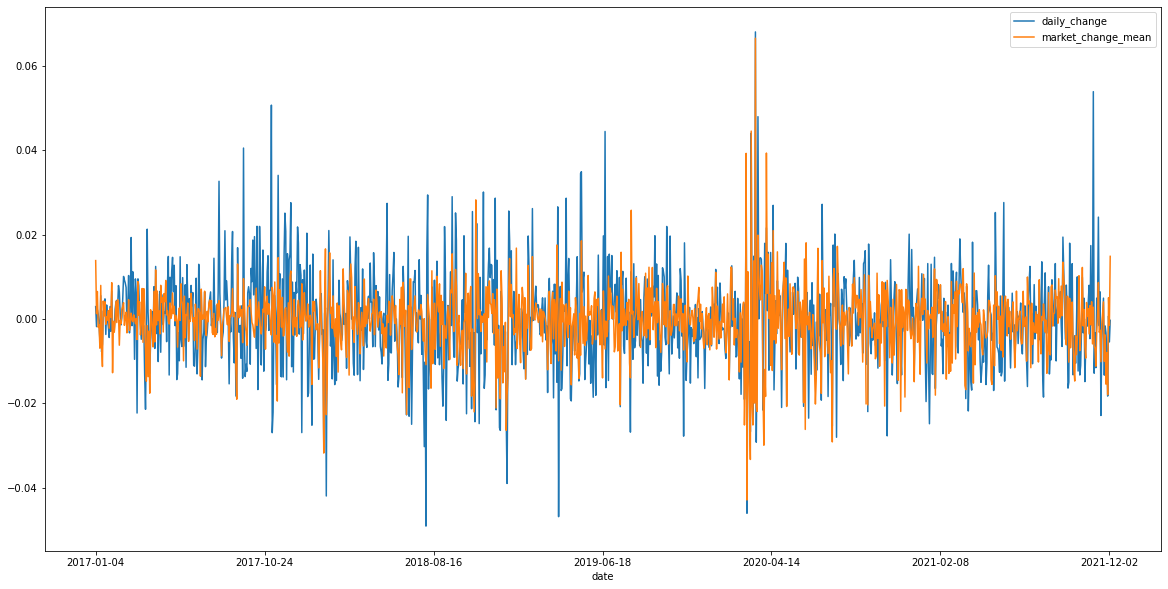

In [88]:
all_stocks_df[all_stocks_df['securities_code'] == 1301].reset_index().plot(x='date',
                                                                           y=["daily_change", "market_change_mean"],
                                                                           kind="line", figsize=(20, 10))

In [89]:
statistics_df = all_stocks_df.groupby(by='securities_code')['market_gap'].agg(['mean', 'median', 'std'])

<AxesSubplot:>

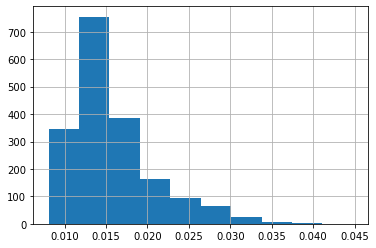

In [90]:
statistics_df['std'].hist()

The stocks with std around 0 (+-) are those that behave LIKE THE MARKET.
We want them to be part of our prediction because they are the least-noisy stocks.

In [91]:
statistics_df.sort_values(by='std', ascending=True, inplace=True)
statistics_df

,mean,median,std
securities_code,,,
8411,-0.000179,-0.000442,0.008062
8316,0.000270,0.000313,0.008394
2914,0.000077,-0.000138,0.008609
2594,0.000370,0.000352,0.008619
8058,0.000541,0.000256,0.008657
...,...,...,...
3856,-0.001491,-0.002401,0.036906
2160,-0.000988,-0.000528,0.038237
2315,-0.002640,-0.001707,0.038699


In [92]:
stable_stocks_statistics_df = statistics_df[:NUMBER_OF_STABLE_STOCKS]

In [93]:
stable_stocks_df = all_stocks_df[all_stocks_df['securities_code'].isin(stable_stocks_statistics_df.index)]
stable_stocks_df

,securities_code,open,close,volume,adjustment_factor,target,adj_open,adj_close,adj_volume,daily_change,market_change_mean,market_gap
date,,,,,,,,,,,,
2017-01-04,1301,2734.0,2742.0,31400,1.0,0.000730,2734.0,2742.0,31400.0,0.002918,0.013817,-0.010900
2017-01-04,1333,3150.0,3210.0,270800,1.0,0.006154,3150.0,3210.0,270800.0,0.018692,0.013817,0.004874
2017-01-04,1377,3270.0,3330.0,150800,1.0,0.003026,3270.0,3330.0,150800.0,0.018018,0.013817,0.004201
2017-01-04,1379,2105.0,2143.0,77300,1.0,0.005169,2105.0,2143.0,77300.0,0.017732,0.013817,0.003915
2017-01-04,1414,4940.0,5050.0,119600,1.0,0.000000,9880.0,10100.0,59800.0,0.021782,0.013817,0.007965
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,9936,5870.0,5980.0,25700,1.0,0.021631,5870.0,5980.0,25700.0,0.018395,0.014824,0.003571
2021-12-03,9945,1903.0,1963.0,59900,1.0,0.013761,1903.0,1963.0,59900.0,0.030565,0.014824,0.015741
2021-12-03,9946,1357.0,1362.0,36700,1.0,0.020101,1357.0,1362.0,36700.0,0.003671,0.014824,-0.011153


In [94]:
assert stable_stocks_df.securities_code.nunique() == NUMBER_OF_STABLE_STOCKS

Get all non-stable stocks:
These are the stocks from which we want to get the ones which are better/worse than the market

In [95]:
extreme_stocks = statistics_df[(NUMBER_OF_STABLE_STOCKS + 1):]

"Top": the stocks which are usually "better" then the market in terms of daily_change (on average)
"Bottom": the stocks which are usually "worse" then the market in terms of daily_change (on average)

In [96]:
top_stocks = extreme_stocks[extreme_stocks['mean'] > 0].sort_values(by=['std'], ascending=True).index.unique()
bottom_stocks = extreme_stocks[extreme_stocks['mean'] < 0].sort_values(by=['std'], ascending=True).index.unique()
top_stocks_df = all_stocks_df[all_stocks_df['securities_code'].isin(top_stocks)]
bottom_stocks_df = all_stocks_df[all_stocks_df['securities_code'].isin(bottom_stocks)]

In [97]:
print(f'There are {len(top_stocks)} top_stocks and {len(bottom_stocks)} bottom_stocks')

There are 739 top_stocks and 740 bottom_stocks


In [98]:
top_stocks_df

,securities_code,open,close,volume,adjustment_factor,target,adj_open,adj_close,adj_volume,daily_change,market_change_mean,market_gap
date,,,,,,,,,,,,
2017-01-04,1407,857.0,866.0,147000,1.0,-0.003437,1448.33,1463.54,86982.248521,0.010393,0.013817,-0.003425
2017-01-04,1419,526.0,535.0,51600,1.0,0.009259,526.00,535.00,51600.000000,0.016822,0.013817,0.003005
2017-01-04,1429,418.0,418.0,24900,1.0,0.007160,418.00,418.00,24900.000000,0.000000,0.013817,-0.013817
2017-01-04,1515,5610.0,5720.0,25200,1.0,-0.026502,5610.00,5720.00,25200.000000,0.019231,0.013817,0.005413
2017-01-04,1518,1298.0,1330.0,124300,1.0,-0.007559,1298.00,1330.00,124300.000000,0.024060,0.013817,0.010243
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,9979,939.0,955.0,72000,1.0,0.032700,939.00,955.00,72000.000000,0.016754,0.014824,0.001930
2021-12-03,9983,66010.0,66650.0,860900,1.0,0.000737,66010.00,66650.00,860900.000000,0.009602,0.014824,-0.005222
2021-12-03,9987,3105.0,3175.0,214000,1.0,0.026856,3105.00,3175.00,214000.000000,0.022047,0.014824,0.007223


In [99]:
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/#:~:text=Here%20is%20a%20short%20snippet%20that%20should%20generally,In%C2%A0%5B4%5D%3A
import sys
!{sys.executable} -m pip install pandas_ta

In [100]:
import pandas_ta as ta


def get_features_for_prediction(df, code):
    """
    Args:
        df (pd.DataFrame)  : pd.DataFrame include stock_price
        code (int)  : A local code for a listed company
    Returns:
        feats DataFrame (pd.DataFrame)
    """
    # close_col = "adj_close"
    feats = df.loc[df['securities_code'] == code, ['securities_code', 'target', 'adj_close', 'adj_volume']].copy()

    for period in DAYS_PERIODS:
        feats[f'return_{period}_days'] = feats['adj_close'].pct_change(period)
        feats[f'volume_{period}_days'] = feats['adj_volume'].pct_change(period)
        feats[f'ema_{period}_days'] = ta.ema(feats['adj_close'], length=period)

    # drop Close column
    #feats = feats.drop(['adj_close'], axis=1)

    # filling data for nan and inf
    feats['adj_volume'] = feats['adj_volume'].fillna(0)
    feats = feats.replace([np.inf, -np.inf], 0)

    return feats

## Generate features:

In [101]:
features = []

for i in [top_stocks_df, bottom_stocks_df]:
    # .reset_index().sort_values(by=['date', 'securities_code'], inplace=True)
    result = pd.concat([get_features_for_prediction(i, code) for code in i['securities_code'].unique()])
    result.reset_index().sort_values(by=['date', 'securities_code'], inplace=True)
    features.append(result)

top_features_df = features[0]
bottom_features_df = features[1]

In [102]:
top_features_df

,securities_code,target,adj_close,adj_volume,return_10_days,volume_10_days,ema_10_days,return_21_days,volume_21_days,ema_21_days,return_63_days,volume_63_days,ema_63_days
date,,,,,,,,,,,,,
2017-01-04,1407,-0.003437,1463.54,86982.248521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,1407,-0.009006,1495.65,47751.479290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,1407,-0.019528,1490.58,31715.976331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,1407,0.004733,1477.06,47514.792899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,1407,0.000000,1448.33,57810.650888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,9997,0.026987,668.00,320800.000000,-0.116402,0.847926,709.682425,-0.170186,1.854093,737.486810,-0.176326,1.204811,800.366979
2021-11-30,9997,-0.001460,667.00,296300.000000,-0.107095,0.132645,701.921984,-0.171429,0.865869,731.078918,-0.176543,1.018392,796.199261
2021-12-01,9997,0.017544,685.00,339100.000000,-0.062927,0.467330,698.845260,-0.141604,0.367339,726.889926,-0.171705,0.420017,792.724284


# MODEL

In [103]:
LGBM_PARAMS = {
    'seed': 42,
    'n_jobs': -1,
}

FEAT_COLS = [
    'return_10_days',
    'volume_10_days',
    'ema_10_days',
    'return_21_days',
    'volume_21_days',
    'ema_21_days',
    'return_63_days',
    'volume_63_days',
    'ema_63_days'
]

In [104]:
# split data into TRAIN and TEST
TRAIN_END = "2019-12-31"
# We put a week gap between TRAIN_END and TEST_START
# to avoid leakage of test data information from label
TEST_START = "2020-01-06"


def get_features_and_label(df):
    """
    Args:
        df (pd.DataFrame): loaded price data with features
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # to store splited data
    trains_X, tests_X = [], []
    trains_y, tests_y = [], []

    # generate feature one by one
    for code in df['securities_code'].unique():
        feats = df[df['securities_code'] == code].dropna().drop(columns='target')
        labels = df.loc[df['securities_code'] == code, ['securities_code', 'target']].dropna()

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # align label and feature indexes
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]

            assert (labels.loc[:, 'securities_code'] == feats.loc[:, 'securities_code']).all()
            labels = labels["target"]

            # split data into TRAIN and TEST
            _train_X = feats[:TRAIN_END]
            _test_X = feats[TEST_START:]

            _train_y = labels[:TRAIN_END]
            _test_y = labels[TEST_START:]

            assert len(_train_X) == len(_train_y)
            assert len(_test_X) == len(_test_y)

            # store features
            trains_X.append(_train_X)
            tests_X.append(_test_X)
            # store labels
            trains_y.append(_train_y)
            tests_y.append(_test_y)

    # combine features for each codes
    train_X = pd.concat(trains_X)
    test_X = pd.concat(tests_X)
    # combine label for each codes
    train_y = pd.concat(trains_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, test_X, test_y

In [105]:
def set_rank(df):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with rank
    """
    # set rank starting from 0
    df.loc[:, "rank"] = np.arange(len(df))
    return df

In [106]:
import sys
!{sys.executable} -m pip install lightgbm

In [107]:
from lightgbm import LGBMRegressor


def get_daily_ranked_results(df: pd.DataFrame, predict_sort_ascending: bool) -> pd.DataFrame:
    # generate feature/label
    train_X, train_y, test_X, test_y = get_features_and_label(df)
    # initialize model
    pred_model = LGBMRegressor(**LGBM_PARAMS)
    # train
    pred_model.fit(train_X[FEAT_COLS].values, train_y)
    # prepare result data
    result = test_X[['securities_code']].copy()
    # predict
    result.loc[:, "predict"] = pred_model.predict(test_X[FEAT_COLS])
    # actual result
    result.loc[:, "target"] = test_y.values
    # sort results by date and ascending/descending "predict", depending on which group we want:
    # the higher the "predict" the more likely to BUY the stock
    # the lower the "predict" the more likely to SELL the stock
    result = result.reset_index().sort_values(["date", "predict"], ascending=[True, predict_sort_ascending])
    # set_rank
    ranked_results = result.groupby('date').apply(set_rank)
    # Drop unnecessary columns. Keep only those which are relevant for submission:
    ranked_results_no_labels_df = ranked_results.reset_index(drop=True).drop(columns=['predict'])

    return ranked_results_no_labels_df.groupby('date').head(NUMBER_OF_DAILY_CHOSEN_STOCKS)

In [108]:
top_daily_chosen_stocks_df = get_daily_ranked_results(top_features_df, predict_sort_ascending=False)
bottom_daily_chosen_stocks_df = get_daily_ranked_results(bottom_features_df, predict_sort_ascending=True)

In [109]:
top_daily_chosen_stocks_df

,date,securities_code,target,rank
0,2020-01-06,4592,-0.017013,0
1,2020-01-06,6080,-0.016797,1
2,2020-01-06,9628,-0.002066,2
3,2020-01-06,4113,-0.059737,3
4,2020-01-06,6382,-0.026263,4
...,...,...,...,...
343766,2021-12-03,3034,0.048148,10
343767,2021-12-03,7864,0.030835,11
343768,2021-12-03,1914,0.032095,12
343769,2021-12-03,3835,0.029316,13


In [110]:
bottom_daily_chosen_stocks_df

,date,securities_code,target,rank
0,2020-01-06,6387,-0.037273,0
1,2020-01-06,1435,-0.027907,1
2,2020-01-06,6378,-0.021676,2
3,2020-01-06,9474,-0.024678,3
4,2020-01-06,2925,-0.020911,4
...,...,...,...,...
344798,2021-12-03,4028,0.056362,10
344799,2021-12-03,5105,0.048005,11
344800,2021-12-03,6640,0.042872,12
344801,2021-12-03,6668,0.012118,13


## Split stable_stocks_statistics_df randomly to 2 groups each with (NUMBER_OF_STABLE_STOCKS / 2) stocks

In [111]:
def random_split_of_list_into_halves(l: list) -> [list, list]:
    random.shuffle(l)
    return l[:int(len(l) / 2)], l[int(len(l) / 2):]

In [112]:
half_1, half_2 = random_split_of_list_into_halves(stable_stocks_statistics_df.index.values)

In [113]:
half_1

array([2670, 9003, 8410, 5201, 6457, 2594, 8355, 1333, 2602, 8418, 5110,
       6902, 8098, 8334, 6702, 6988, 6741, 8860, 8022, 9432, 7487, 1928,
       4401, 7483, 2229, 7817, 3543, 2686, 2664, 6282, 9041, 9735, 2702,
       6417, 8354, 4665, 7912, 7984, 5333, 8385, 8601, 1926, 1925, 9005,
       8707, 9412, 7203, 6501, 7267, 9045, 2753, 5261, 9052, 2206, 3075,
       8377, 3591, 8200, 4063, 8359, 9404, 2004, 8306, 4540, 4204, 6965,
       4452, 8041, 2001, 9042, 7966, 4088, 4550, 6367, 9744, 8068, 2768,
       4118, 8060, 8058, 4527, 9831, 5262, 8511, 3863, 4114, 9022, 9708,
       6436, 9364, 9934, 1762, 8368, 9661, 8074, 9504, 9832, 4634, 6178,
       8218, 7751, 3159, 5933, 9046, 7272, 8541, 9048, 3291, 4044, 7512,
       8591, 8341, 9534, 5930, 9433, 9795, 3231, 2573, 1414, 9069, 9728,
       7313, 9436, 1805, 1941, 9945, 3167, 8140, 7510, 4521, 2922, 4005,
       7182, 9882, 7611, 4559, 8802, 2296, 9044, 2751, 1833, 9001, 1780,
       6257, 9948, 2288, 1301, 1944, 3050, 9508, 28

In [114]:
# making sure even split and enough stocks in every half
assert len(half_1) + len(half_2) == NUMBER_OF_STABLE_STOCKS

## Concat top_daily_chosen_stocks_df + stable half + stable half + bottom_daily_chosen_stocks_df

In [116]:
stable_stocks_df

,securities_code,open,close,volume,adjustment_factor,target,adj_open,adj_close,adj_volume,daily_change,market_change_mean,market_gap
date,,,,,,,,,,,,
2017-01-04,1301,2734.0,2742.0,31400,1.0,0.000730,2734.0,2742.0,31400.0,0.002918,0.013817,-0.010900
2017-01-04,1333,3150.0,3210.0,270800,1.0,0.006154,3150.0,3210.0,270800.0,0.018692,0.013817,0.004874
2017-01-04,1377,3270.0,3330.0,150800,1.0,0.003026,3270.0,3330.0,150800.0,0.018018,0.013817,0.004201
2017-01-04,1379,2105.0,2143.0,77300,1.0,0.005169,2105.0,2143.0,77300.0,0.017732,0.013817,0.003915
2017-01-04,1414,4940.0,5050.0,119600,1.0,0.000000,9880.0,10100.0,59800.0,0.021782,0.013817,0.007965
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,9936,5870.0,5980.0,25700,1.0,0.021631,5870.0,5980.0,25700.0,0.018395,0.014824,0.003571
2021-12-03,9945,1903.0,1963.0,59900,1.0,0.013761,1903.0,1963.0,59900.0,0.030565,0.014824,0.015741
2021-12-03,9946,1357.0,1362.0,36700,1.0,0.020101,1357.0,1362.0,36700.0,0.003671,0.014824,-0.011153


In [122]:
def get_final_ranks_df(top_df: pd.DataFrame, stable_stock_list: list, stable_stocks_df: pd.DataFrame,
                       bottom_df: pd.DataFrame) -> pd.DataFrame:
    result_df = pd.DataFrame()

    for d in top_df['date'].unique():
        first_half, second_half = random_split_of_list_into_halves(stable_stock_list)
        result_df = pd.concat([result_df,
                               top_df[top_df['date'] == d],
                               stable_stocks_df.loc[(stable_stocks_df.index == d) & (
                                   stable_stocks_df['securities_code'].isin(first_half)), ['securities_code',
                                                                                           'target']].reset_index(),
                               stable_stocks_df.loc[(stable_stocks_df.index == d) & (
                                   stable_stocks_df['securities_code'].isin(second_half)), ['securities_code',
                                                                                            'target']].reset_index(),
                               bottom_df[bottom_df['date'] == d][::-1]])
        # need to reverse bottom stocks

    return result_df


final_ranks_df = get_final_ranks_df(top_daily_chosen_stocks_df, stable_stocks_statistics_df.index.values,
                                    stable_stocks_df,
                                    bottom_daily_chosen_stocks_df)

## re-rank concatenated daily

In [123]:
final_ranks_df = final_ranks_df.groupby('date').apply(set_rank).reset_index(drop=True)
# final_ranks_df.date.value_counts().unique()  # 400 every day
final_ranks_df

,date,securities_code,target,rank
0,2020-01-06,4592,-0.017013,0
1,2020-01-06,6080,-0.016797,1
2,2020-01-06,9628,-0.002066,2
3,2020-01-06,4113,-0.059737,3
4,2020-01-06,6382,-0.026263,4
...,...,...,...,...
187195,2021-12-03,3180,-0.023384,395
187196,2021-12-03,6779,0.159624,396
187197,2021-12-03,4310,0.040240,397
187198,2021-12-03,7715,0.049623,398


# Calculate score

In [125]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """

    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['rank'].min() == 0
        assert df['rank'].max() == len(df['rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='rank')['target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='rank', ascending=False)['target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()

    return sharpe_ratio

In [126]:
score = calc_spread_return_sharpe(final_ranks_df, portfolio_size=200, toprank_weight_ratio=2)
score

0.05806327574398995

# SUBMIT
Will not work on local run!
Must be run through Kaggle's Kernel - open a notebook there and copy this notebook

In [ ]:
import jpx_tokyo_market_prediction

env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [ ]:
# The API will deliver six dataframes in this specific order:
counter = 0

for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    #     if counter == 0:
    #         print(prices.head())
    #         print(options.head())
    #         print(financials.head())
    #         print(trades.head())
    #         print(secondary_prices.head())
    #         print(sample_prediction.head())
    sample_prediction['rank'] = np.arange(len(sample_prediction))
    env.predict(sample_prediction)
    counter += 1

In [ ]:
! head submission.csv